*Análisis y limpieza de Datos*<br>
*Magister y Diplomado en Data Science*
# Análisis de los factores asociados a la tasa de mortalidad por traumatismos
**Profesor:** Victor Landaeta<br>
**Estudiantes:** <br>Catalina Quijada<br>Claudia Fernandino<br>Patricio Céspedes

## Introducción
Uno de los principales ámbitos de estudio en salud pública son los Determinantes Sociales de la Salud (DSS), definidos por la OMS como "las condiciones de vida que son causa de buena parte de las inequidades sanitarias entre los países y dentro de cada país" (OMS, 2009). Estudios anteriores (Bilal, Alazraqui, Caiaffa, Lopez-Olmedo, Martinez-Folgar, Miranda, et. al., 2019) han mostrado que los habitantes de las comunas de mayores ingresos de la Región Metropolitana tienen una mayor esperanza de vida que aquellos de comunas de menores ingresos, de modo que es interesante analizar si esas diferencias en la esperanza de vida se asocian a su vez a diferentes causas de muerte. Una de las principales causas de muertes a temprana y mediana edad actualmente en Chile tiene relación con los 'traumatismos, envenenamientos y otras consecuencias de causas externas' (en adelante, traumatismos), por lo que surge la interrogante respecto a si existen diferencias en la tasa de mortalidad según nivel socioeconómico de la comuna.<br>Sin embargo, también es necesario analizar qué ocurre en el resto de las regiones del país, ya que en estas no existe una asociación tan clara con el nivel socioeconómico, por lo que es posible que existan otros factores que incidan en la tasa de mortalidad. En este sentido, otras variables que podrían influir son la proporción de población rural, proporción de población que se identifica con un pueblo originario, tasa de denuncia de delitos de mayor connotación social y tiempo promedio en minutos al hospital o clínica más cercana a la entidad rural.<br>La pregunta que se espera responder es ¿existe asociación entre el nivel socioeconómico y la tasa de mortalidad por traumatismos, en la Región Metropolitana y el resto de las regiones de Chile? La hipótesis es que a mayor nivel socioeconómico de la comuna, menor es la tasa de mortalidad por traumatismos. Respecto a las otras variables, se espera que a mayor tasa de población rural la tasa de mortalidad por traumatismos sea mayor, ya que esto podría dificultar el acceso a centros asistenciales y, por ende, este tipo de situaciones es más probable que termine en muerte. En cuanto a la proporción de población que se identifica con un pueblo originario, la hipótesis es que en la medida que aumenta este indicador, aumenta la tasa de mortalidad por traumatismos, lo cual podría deberse a la existencia de factores culturales que devengan en una mayor aprensión a ciertos tratamientos. Por otra parte, se espera que una mayor tasa de denuncias de delitos de mayor connotación social se asocie a una mayor tasa de defunciones por traumatismos, debido a que las personas que viven en estas comunas están expuestas a un ambiente más violento y, por ende, a una mayor probabilidad de morir por estos motivos. Por último, respecto a la variable tiempo promedio en minutos al hospital o clínica más cercana a la localidad rural, se espera que la mortalidad por traumatismos sea mayor en aquellas comunas en que el tiempo de traslado sea mayor.

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Type

## Metodología
La unidad de análisis del estudio es la comuna. Cuenta con representatividad a nivel nacional, aunque se excluyen aquellas para las cuales no se cuenta con información en Casen 2017. Estas son: Isla de Pascua, Cochamó, Chaitén, Futaleufú, Hualaihué, Primavera, Colchane, Ollagüe, Juan Fernández, Palena, Lago Verde, Guaitecas, O'Higgins, Tortel, Laguna Blanca, Río Verde, San Gregorio, Cabo de Hornos, Antártica, Timaukel, Torres del Paine y General Lagos.<br> Los datos sobre muertes por traumatismos se obtuvieron de la página web del [DEIS](https://deis.minsal.cl/), la cual cuenta con información desde 2016 a 2021 sobre las muertes ocurridas y sus respectivas causas. Se decidió trabajar con el año 2017, ya que para estimar el promedio de ingresos por comuna y la proporción de población que se identifica con un pueblo originario es necesario utilizar la Encuesta Casen, cuyas últimas versiones son 2017 y 2020. Sin embargo, si bien lo más lógico sería utilizar la versión más reciente, en el año 2020 la mortalidad está fuertemente influenciada por la pandemia de Covid-19, la cual llegó a ser la primera causa de muerte en Chile, por lo que, al ser un año atípico, las tasas de mortalidad podrían estar influenciadas por este fenómeno y, por lo tanto, los resultados podrían no reflejar la asociación entre las variables que se desean estudiar. Cabe mencionar que la Encuesta Casen cuenta con diversos indicadores de ingresos, sin embargo, se utiliza el promedio per cápita autónomo del hogar, el cual controla por el número de miembros del hogar y, al no incluir subsidios ni otras ayudas del Estado, refleja de mejor forma los ingresos que producen las personas de forma independiente. Por otro lado, para calcular la tasa de mortalidad se debe contar con el tamaño de la población, la cual se obtuvo de las proyecciones de población realizadas por el [INE](https://www.ine.cl/estadisticas/sociales/demografia-y-vitales/proyecciones-de-poblacion). Esta información también se utilizó para calcular la proporción de población rural dentro de la comuna. En relación a la tasa de denuncias de delitos de mayor connotación social, esta se obtuvo de la página web de la [Biblioteca del Congreso Nacional](https://www.bcn.cl/siit/estadisticasterritoriales/tema?id=63), mientras que el tiempo promedio en minutos al hospital o clínica más cercano es un indicador calculado por el INE y que forma parte del [Sistema de Indicadores de Calidad de Vida Rural](https://www.ine.cl/herramientas/portal-de-mapas/sicvir).<br> El análisis de los datos se divide en dos partes. En primer lugar, se realiza un análisis descriptivo para explorar la correlación entre la variable a explicar (tasa de mortalidad por traumatismos) y las explicativas (promedio de ingresos por hogar, proporción de población rural, proporción de personas que se identifica con un pueblo originario y tasa de denuncia de delitos de mayor connotación social). En segundo lugar, se estiman modelos de regresión simple y múltiple, para indagar más en la asociación entre las variables. En ambos casos, el análisis se realiza a nivel nacional, y luego de forma separada para las comunas de la Región Metropolitana y el resto de las comunas, con la finalidad de explorar si la asociación entre las variables analizadas es diferente en ambos grupos de comunas.

In [2]:
data_total = pd.read_csv('https://raw.githubusercontent.com/CatitaR/CapstoneProject_ADD/main/data/processed/base_analisis.csv')
data_rm = pd.read_csv('https://raw.githubusercontent.com/CatitaR/CapstoneProject_ADD/main/data/processed/base_analisis_rm.csv')
data_otras = pd.read_csv('https://raw.githubusercontent.com/CatitaR/CapstoneProject_ADD/main/data/processed/base_analisis_otras.csv')
data_otras2 = pd.read_csv('https://raw.githubusercontent.com/CatitaR/CapstoneProject_ADD/main/data/processed/base_analisis_otras2.csv')

## Resultados
### Análisis descriptivo
En la siguiente tabla se observa la matriz de correlación entre las variables a analizar, para todas las comunas del país. Entre la tasa de defunciones por traumatismos y la proporción de población rural, existe una correlación positiva, la cual llega a 0.33. Algo similar ocurre entre la tasa de defunciones por traumatismos y la proporción de población que se identifica con un pueblo originario, cuya correlación es de 0.27. Por otro lado, entre la tasa de defunciones y los ingresos la correlación es negativa, con un coeficiente de -0.26, mientras que respecto a la tasa de denuncias de delitos de mayor connotación social se observa la misma tendencia, aunque la correlación es más suave (-0.15).

In [3]:
data_total[['tasa_def','prop_rural','etnia','ingreso','tasa_denuncias']].corr()

,tasa_def,prop_rural,etnia,ingreso,tasa_denuncias
tasa_def,1.000000,0.333822,0.273611,-0.265321,-0.155897
prop_rural,0.333822,1.000000,0.311531,-0.383921,-0.291506
etnia,0.273611,0.311531,1.000000,-0.137925,-0.174545
ingreso,-0.265321,-0.383921,-0.137925,1.000000,0.312979
tasa_denuncias,-0.155897,-0.291506,-0.174545,0.312979,1.000000


En el caso de las comunas de la Región Metropolitana, la correlación entre la tasa de defunción y la proporción de población rural es positiva, aunque muy baja. En cambio, la correlación con la etnia e ingresos siguen la misma tendencia que a nivel nacional, pero son correlaciones más fuertes, llegando a 0.39 y -0.52, respectivamente. En cuanto a la correlación con la tasa de denuncias, esta también es muy baja (-0.08)

In [4]:
data_rm[['tasa_def','prop_rural','etnia','ingreso','tasa_denuncias']].corr()

,tasa_def,prop_rural,etnia,ingreso,tasa_denuncias
tasa_def,1.000000,0.088934,0.386770,-0.523736,-0.077334
prop_rural,0.088934,1.000000,-0.125432,-0.217116,-0.232757
etnia,0.386770,-0.125432,1.000000,-0.427525,-0.172136
ingreso,-0.523736,-0.217116,-0.427525,1.000000,0.213438
tasa_denuncias,-0.077334,-0.232757,-0.172136,0.213438,1.000000


En el resto de las comunas del país, la correlación entre la tasa de defunción y la proporción de población es más fuerte, llegando a 0.28. En cambio, la asociación de la variable a explicar con la etnia y el promedio de ingresos y la tasa de denuncias, si bien sigue la misma tendencia que en la Región Metropolitana, el coeficiente es menor (0.24 y -0.23, respectivamente). Respecto a la tasa de denuncias, la correlación es más fuerte que en las comunas de la Región Metropolitana, pero menos que en el total país.

In [5]:
data_otras[['tasa_def','prop_rural','etnia','ingreso','tasa_denuncias']].corr()

,tasa_def,prop_rural,etnia,ingreso,tasa_denuncias
tasa_def,1.000000,0.286528,0.237881,-0.225657,-0.126749
prop_rural,0.286528,1.000000,0.290781,-0.494263,-0.255537
etnia,0.237881,0.290781,1.000000,-0.089675,-0.191956
ingreso,-0.225657,-0.494263,-0.089675,1.000000,0.253904
tasa_denuncias,-0.126749,-0.255537,-0.191956,0.253904,1.000000


### Modelos de regresión
A continuación, se presentan los resultados del modelo 1, el cual es una regresión lineal simple, cuya variable dependiente es la tasa de defunciones para traumatismos y la explicativa es el promedio de ingresos, para todas las comunas del país. Se observa que el coeficiente de correlación es negativo, es decir, a mayor ingreso disminuye la tasa de defunciones. Asimismo, la prueba de significancia estadística indica que se rechaza la hipótesis nula, por lo que es posible concluir que existe una asociación entre las variables analizadas. Sin embargo, cabe mencionar que el R cuadrado del modelo es bastante bajo, alcanzando solamente 0.07

In [6]:
mod1 = smf.ols(formula='tasa_def ~ ingreso', data=data_total)
res1 = mod1.fit()
print('Modelo 1: modelo regresión lineal simple (ingresos sobre tasa de defunciones por traumatismos) para todas las comunas del país')
print(res1.summary())

Modelo 1: modelo regresión lineal simple (ingresos sobre tasa de defunciones por traumatismos) para todas las comunas del país
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     24.38
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           1.27e-06
Time:                        20:32:59   Log-Likelihood:                -1508.7
No. Observations:                 324   AIC:                             3021.
Df Residuals:                     322   BIC:                             3029.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

En el caso de la Región Metropolitana, el modelo de regresión simple indica que existe una asociación negativa entre la tasa de defunciones por traumatismos y el promedio de ingresos de la comuna (modelo 2). Cabe mencionar que, en este caso, el R cuadrado obtenido es mayor (0.27), por lo que la variable ingresos explica mejor la tasa de defunciones en las comunas de la Región Metropolitana, que en el total de las comunas de las otras regiones.

In [7]:
mod2 = smf.ols(formula='tasa_def ~ ingreso', data=data_rm)
res2 = mod2.fit()
print('Modelo 2: modelo regresión lineal simple (ingresos sobre tasa de defunciones por traumatismos) para las comunas de la Región Metropolitana')
print(res2.summary())

Modelo 2: modelo regresión lineal simple (ingresos sobre tasa de defunciones por traumatismos) para las comunas de la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     18.90
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           6.76e-05
Time:                        20:32:59   Log-Likelihood:                -189.94
No. Observations:                  52   AIC:                             383.9
Df Residuals:                      50   BIC:                             387.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

Para el grupo de comunas no pertenecientes a la Región Metropolitana, el modelo de regresión lineal simple también indica que existe una asociación negativa entre los ingresos y la tasa de defunción de la comuna (modelo 3). Si bien este coeficiente es significativo, el R cuadrado solamente es de 0.051, por lo que la variable ingresos explica una parte muy baja de la varianza de la tasa de defunciones por traumatismos.

In [8]:
mod3 = smf.ols(formula='tasa_def ~ ingreso', data=data_otras)
res3 = mod3.fit()
print('Modelo 3: modelo regresión lineal simple (ingresos sobre tasa de defunciones por traumatismos) para las comunas no pertenecientes a la Región Metropolitana')
print(res3.summary())

Modelo 3: modelo regresión lineal simple (ingresos sobre tasa de defunciones por traumatismos) para las comunas no pertenecientes a la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     14.49
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           0.000175
Time:                        20:32:59   Log-Likelihood:                -1280.0
No. Observations:                 272   AIC:                             2564.
Df Residuals:                     270   BIC:                             2571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

A continuación, se estiman modelos de regresión múltiples, agregando como variables de control la proporción de población rural, proporción que se identifica con un pueblo originario y la tasa de denuncias de delitos de mayor connotación social. Respecto a la asociación entre ingresos y la tasa de defunciones por traumatismos, el modelo 4 indica que, manteniendo el resto de las variables constantes, existe una asociación negativa y la prueba de hipótesis indica que este coeficiente es significativo. En cuanto a las variables proporción de población rural y proporción que se identifica con un pueblo originario, la asociación con la tasa de defunciones es positiva y significativa, es decir, en la medida que aumenta tanto la población rural como la identificación, aumenta la tasa de defunciones por traumatismos. Por último, en cuanto a la tasa de denuncias de delitos de mayor connotación social, si bien el coeficiente es negativo, no es significativo, por lo que no es posible afirmar que existe una asociación con esta variable.<br>Por último, cabe mencionar que el R cuadrado de este modelo es de 0.164, lo cual es mayor al 0.07 del modelo que incluye solamente la variable ingresos, por lo que las demás variables incorporadas son un aporte para explicar la tasa de defunciones por traumatismos.

In [9]:
mod4 = smf.ols(formula='tasa_def ~ ingreso + prop_rural + etnia + tasa_denuncias', data=data_total)
res4 = mod4.fit()
params4 = res4.params
print('Modelo 4: modelo regresión lineal múltiple para todas las comunas del país')
print(res4.summary())

Modelo 4: modelo regresión lineal múltiple para todas las comunas del país
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     15.69
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           9.79e-12
Time:                        20:32:59   Log-Likelihood:                -1491.4
No. Observations:                 324   AIC:                             2993.
Df Residuals:                     319   BIC:                             3012.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

En la Región Metropolitana, el modelo 5 indica que existe un coeficiente negativo y significativo en la variable ingresos, manteniendo las demás variables constantes. Sin embargo, para el resto de las variables, el coeficiente no es significativo. Por lo tanto, es posible afirmar que, en las comunas de la Región Metropolitana, a mayor nivel de ingresos, menor es la tasa de defunciones por traumatismos, controlando por el resto de las variables. <br>Cabe destacar que, si bien el resto de las variables no tiene un coeficiente significativo, el R cuadrado del modelo llega a 0.311, siendo mayor que el del modelo que incluye solamente el promedio de ingresos como variable explicativa (0.27). Sin embargo, los indicadores de bondad de ajuste BIC y AIC, son mayores, lo que indicaría que no necesariamente el modelo es mejor.

In [10]:
mod5 = smf.ols(formula='tasa_def ~ ingreso + prop_rural + etnia + tasa_denuncias', data=data_rm)
res5 = mod5.fit()
params5 = res5.params
print('Modelo 5: modelo regresión lineal múltiple para las comunas de la Región Metropolitana')
print(res5.summary())

Modelo 5: modelo regresión lineal múltiple para las comunas de la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     5.291
Date:                Sun, 16 Oct 2022   Prob (F-statistic):            0.00133
Time:                        20:32:59   Log-Likelihood:                -188.61
No. Observations:                  52   AIC:                             387.2
Df Residuals:                      47   BIC:                             397.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

En las comunas que no pertenecen a la Región Metropolitana, al agregar las variables de control, se observa que el promedio de ingresos ya no tiene un coeficiente de regresión significativo con la tasa de defunciones por traumatismos (modelo 6). Sin embargo, tanto la proporción de población rural como la que pertenece a un pueblo originario tienen una coeficiente positivo y significativo con la variable explicada, y los coeficientes son significativos, por lo que es posible afirmar que existe una asociación positiva entre estas variables y la tasa de defunciones. Asimismo, respecto al modelo que solamente incluye la variable ingresos como explicativa, el R cuadrado es mayor, pasando de 0.051 a 0.12. Asimismo, los indicadores AIC y BIC son menores, lo que indicaría que este modelo es mejor para explicar la tasa de defunciones en las comunas no pertenecientes a la Región Metropolitana.

In [11]:
mod6 = smf.ols(formula='tasa_def ~ ingreso + prop_rural + etnia + tasa_denuncias', data=data_otras)
res6 = mod6.fit()
params6 = res6.params
print('Modelo 6: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana')
print(res6.summary())

Modelo 6: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     9.107
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           6.55e-07
Time:                        20:32:59   Log-Likelihood:                -1269.7
No. Observations:                 272   AIC:                             2549.
Df Residuals:                     267   BIC:                             2567.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Los resultados anteriores muetran que, en el caso de la Región Metropolitana, el promedio de ingreso per cápita de los hogares tiene una asociación negativa con la tasa de defunciones por traumatismos, manteniendo el resto de las variables constantes. En cambio, en las comunas que no pertenecen a la RM, no es posible afirmar que ocurra esta misma relación, ya que el coeficiente no es significativo. Sin embargo, sí es posible concluir que una mayor proporción de población rural y de población que se identifica con un pueblo originario se asocian a una mayor tasa de mortalidad por traumatismos, manteniendo el resto de las variables constantes. Por lo tanto, las características de las comunas que se asocian, ya sea negativa o positivamente, con la tasa de defunciones por traumatismos, varían según si la comuna pertenece o no a la Región Metropolitana.

En el siguiente gráfico se observa la asociación entre las variables 'ingresos' y 'tasa de defunciones por traumatismos', así como el coeficienete de regresión del modelo que controla por el resto de las variables, en las comunas de la Región Metropolitana. A partir de la observación de este gráfico es posible obtener dos conclusiones: primero, la existencia de un posible efecto no lineal entre las variables mencionadas y, segundo, que hay cinco comunas que tienen un comportamiento distinto y se alejan de la nube de puntos donde se encuentra el resto de las comunas.

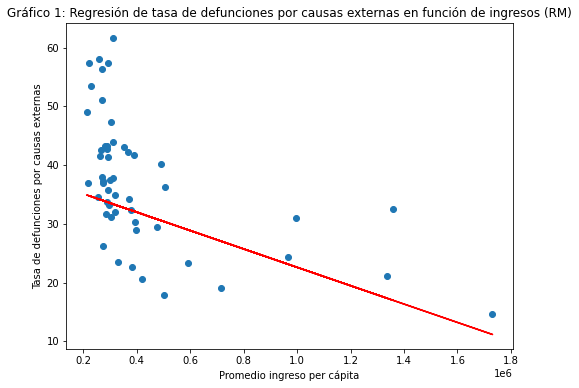

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(data_rm['ingreso'], data_rm['tasa_def'], "o", label="Data")
ax.plot(data_rm['ingreso'], params5['Intercept']+params5['ingreso']*data_rm['ingreso']  , "r-", label="Predicted")
ax.set_ylabel("Tasa de defunciones por causas externas")
ax.set_xlabel("Promedio ingreso per cápita")
ax.set_title("Gráfico 1: Regresión de tasa de defunciones por causas externas en función de ingresos (RM)")
plt.show()

En el siguiente gráfico se observa la asociación entre las variables 'ingresos' y 'tasa de defunciones por traumatismos', así como el coeficienete de regresión del modelo que controla por el resto de las variables, en las comunas del país que se encuentran fuera de la Región Metropolitana. Al comparar este gráfico con el anterior, es claro que la nube de puntos es mucho más dispersa, lo que se condice con el hecho de que el coeficiente de regresión no sea significativo.

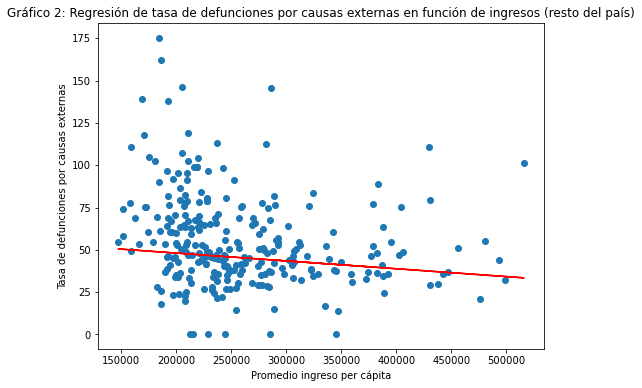

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(data_otras['ingreso'], data_otras['tasa_def'], "o", label="Data")
ax.plot(data_otras['ingreso'], params6['Intercept']+params6['ingreso']*data_otras['ingreso']  , "r-", label="Predicted")
ax.set_ylabel("Tasa de defunciones por causas externas")
ax.set_xlabel("Promedio ingreso per cápita")
ax.set_title("Gráfico 2: Regresión de tasa de defunciones por causas externas en función de ingresos (resto del país)")
plt.show()

Tal como se mencionó anteriormente, en el gráfico se observa que posiblemente existe una asociación no lineal entre los ingresos y la tasa de defunciones, en las comunas de la Región Metropolitana. Para explorar esto, se aplica transformación logarítmica sobre ambas variables y luego se estima el modelo con todas las variables. Los resultados indican que también existe una asociación negativa, con un coeficiente significativo, manteniendo el resto de las variables constantes. Sin embargo, lo más interesante es que este modelo tiene un R cuadrado superior al modelo 5 (donde no se aplicó la transformación logarítmica), y los indicadores de BIC y AIC son bastante menores. Por lo tanto, la transformación logarítmica permite predecir de mejor forma el comportamiento de la tasa de defunción por traumatismos, en las comunas de la Región Metropolitana.

In [14]:
data_rm['tasa_def_log'] = np.log(data_rm['tasa_def'])
data_rm['ingreso_log'] = np.log(data_rm['ingreso'])

In [15]:
mod7 = smf.ols(formula='tasa_def_log ~ ingreso_log + prop_rural + etnia + tasa_denuncias', data=data_rm)
res7 = mod7.fit()
params7 = res7.params
print('Modelo 7: modelo regresión lineal múltiple con transformación logarítmica, para las comunas de la Región Metropolitana')
print(res7.summary())

Modelo 7: modelo regresión lineal múltiple con transformación logarítmica, para las comunas de la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:           tasa_def_log   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     9.540
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           9.90e-06
Time:                        20:32:59   Log-Likelihood:                 1.2842
No. Observations:                  52   AIC:                             7.432
Df Residuals:                      47   BIC:                             17.19
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------

En el gráfico a continuación se observa la asociación entre las variables tasa de defunciones por traumatismos e ingresos de la comuna, ambos transformadas logarítmicamente, así como el coeficiente de correlación del modelo con el resto de las variables de control. Respecto al gráfico del modelo sin la transformación logarítmica, se observa que la nube de puntos es más homogénea y la pendiente es más pronunciada. Sin embargo, se siguen notando cinco comunas que tienen un comportamiento atípico. 

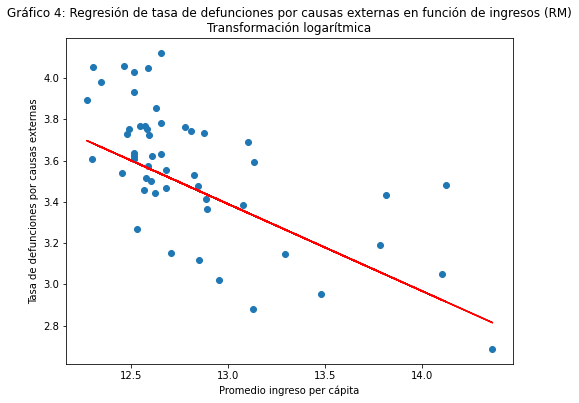

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(data_rm['ingreso_log'], data_rm['tasa_def_log'], "o", label="Data")
ax.plot(data_rm['ingreso_log'], params7['Intercept']+params7['ingreso_log']*data_rm['ingreso_log']  , "r-", label="Predicted")
ax.set_ylabel("Tasa de defunciones por causas externas")
ax.set_xlabel("Promedio ingreso per cápita")
ax.set_title("Gráfico 4: Regresión de tasa de defunciones por causas externas en función de ingresos (RM)\nTransformación logarítmica")
plt.show()

In [17]:
# base code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance 
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty. 
        Please test the code one your end before using.
    """

    def __init__(self, 
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]): 
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")     

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()
        
        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict, 
            y=self.residual, 
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, 
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i, 
                xy=(self.y_predict[i], self.residual[i]), 
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()
        
        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i, 
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]), 
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax
  
    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict, 
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, 
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i, 
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]), 
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage, 
            self.residual_norm, 
            alpha=0.5);
        
        sns.regplot(
            x=self.leverage, 
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i, 
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')
        
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the 
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))
        

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams 
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

En el siguiente gráfico se observan los residuos del modelo que incluye la transformación logarítmica de las variables ingresos y tasa de defunciones. Nuevamente destacan las cinco comunas con un comportamiento atípico, en las cuales los residuos también tienen un comportamiento distinto. Dado lo anterior, se eliminan de la base de datos las cinco comunas con el mayor promedio de ingresos (Vitacura, Providencia, Las Condes, La Reina y Ñuñoa) y se estiman nuevamente los modelos de regresión, con y sin transformación logarítmica.

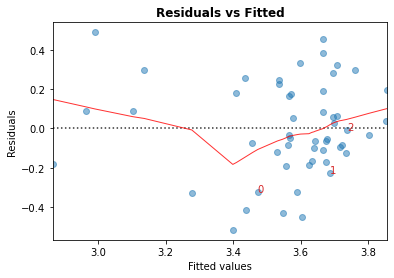

In [18]:
cls = Linear_Reg_Diagnostic(res7)
cls.residual_plot();

Respecto al modelo sin la transformación logarítmica y eliminando las cinco comunas con más ingresos de la Región Metropolitana (modelo 8), sigue existiendo una asociación negativa entre ingresos y tasa de defunciones por traumatismos, controlando por el resto de las variables, en las comunas de la Región Metropolitana. Sin embargo, al comparar este modelo con el que incluye todas las comunas (modelo 5), el R cuadrado es mayor y los indicadores AIC y BIC son menores, lo que indica que al eliminar las cinco comunas mencionadas, el poder predictivo del modelo es mejor.

In [19]:
data_rm2 = data_rm[(data_rm['Nombre Comuna']!='Vitacura')&
                    (data_rm['Nombre Comuna']!='Providencia')&
                    (data_rm['Nombre Comuna']!='Las Condes')&
                   (data_rm['Nombre Comuna']!='La Reina')&
                   (data_rm['Nombre Comuna']!='Ñuñoa')]

In [20]:
mod8 = smf.ols(formula='tasa_def ~ ingreso + prop_rural + etnia + tasa_denuncias', data=data_rm2)
res8 = mod8.fit()
params8 = res8.params
print('Modelo 8: modelo regresión lineal múltiple eliminando las cinco comunas de más ingreso, para las comunas de la Región Metropolitana')
print(res8.summary())

Modelo 8: modelo regresión lineal múltiple eliminando las cinco comunas de más ingreso, para las comunas de la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     6.842
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           0.000246
Time:                        20:33:00   Log-Likelihood:                -165.55
No. Observations:                  47   AIC:                             341.1
Df Residuals:                      42   BIC:                             350.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.

En el gráfico a continuación se presenta la asociación de las variables tasa de defunciones por traumatismos y promedio de ingresos, y el coeficiente de regresión del modelo 8. Se observa que la nube de puntos es bastante homogénea, y los valores son bien cercanos a la línea que representa el coeficiente de regresión.

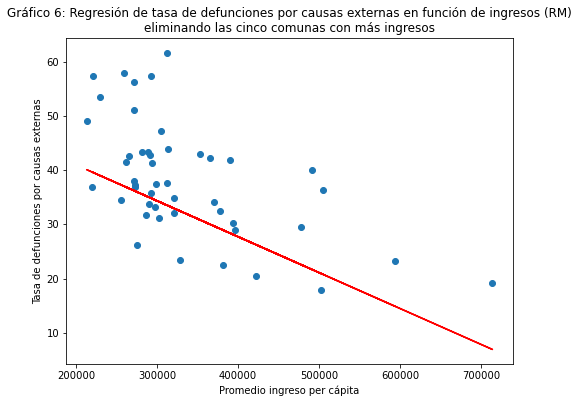

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(data_rm2['ingreso'], data_rm2['tasa_def'], "o", label="Data")
ax.plot(data_rm2['ingreso'], params8['Intercept']+params8['ingreso']*data_rm2['ingreso']  , "r-", label="Predicted")
ax.set_ylabel("Tasa de defunciones por causas externas")
ax.set_xlabel("Promedio ingreso per cápita")
ax.set_title("Gráfico 6: Regresión de tasa de defunciones por causas externas en función de ingresos (RM)\neliminando las cinco comunas con más ingresos")
plt.show()

A continuación, se presentan los resultados del modelo 9, el cual elimina las cinco comunas de la Región Metropolitana con más ingresos y aplica transformación logarítmica a las variables promedio de ingresos por hogar y tasa de defunciones por traumatismos. La tendencia es la misma que en el modelo 7, observándose una asociación negativa entre ingresos y la tasa de defunciones por traumatismos, con un coeficiente de regresión significativo, manteniendo el resto de las variables constantes. Respecto a las demás variables del modelo, no es posible afirmar que existe una asociación, ya que los test de hipótesis no permiten rechazar la hipótesis nula. En cuanto a la bondad del ajuste, este modelo es el que tiene mayor R cuadrado y menores AIC y BIC, en comparación al resto de los modelos para las comunas de la Región Metropolitana, por lo que es el que explica mejor la variable tasa de defunciones por traumatismos.

In [22]:
mod9 = smf.ols(formula='tasa_def_log ~ ingreso_log + prop_rural + etnia + tasa_denuncias', data=data_rm2)
res9 = mod9.fit()
params9 = res9.params
print('Modelo 9: modelo regresión lineal múltiple con transformación logarítmica y eliminando las cinco comunas de más ingresos, para las comunas de la Región Metropolitana')
print(res9.summary())

Modelo 9: modelo regresión lineal múltiple con transformación logarítmica y eliminando las cinco comunas de más ingresos, para las comunas de la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:           tasa_def_log   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     8.729
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           3.19e-05
Time:                        20:33:00   Log-Likelihood:                 5.5157
No. Observations:                  47   AIC:                            -1.031
Df Residuals:                      42   BIC:                             8.219
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err        

En el siguiente gráfico, se observa la asociación entre la tasa de defunciones por causas externas e ingresos, eliminando las cinco comunas con mayores ingresos y aplicando transformación logarítmica, así como el coeficiente de regresión del modelo 9. Asimismo, en el gráfico posterior, se observa que los residuos tienen una distribución más homogénea.

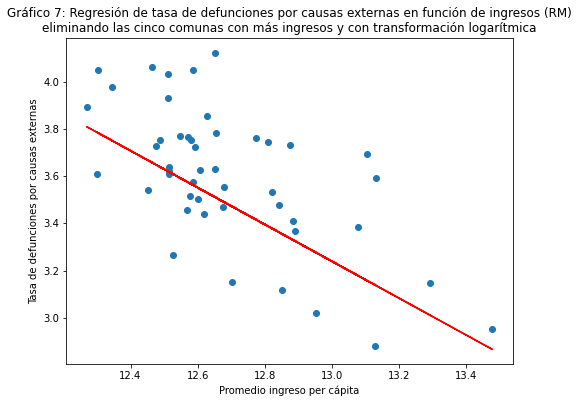

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(data_rm2['ingreso_log'], data_rm2['tasa_def_log'], "o", label="Data")
ax.plot(data_rm2['ingreso_log'], params9['Intercept']+params9['ingreso_log']*data_rm2['ingreso_log']  , "r-", label="Predicted")
ax.set_ylabel("Tasa de defunciones por causas externas")
ax.set_xlabel("Promedio ingreso per cápita")
ax.set_title("Gráfico 7: Regresión de tasa de defunciones por causas externas en función de ingresos (RM)\neliminando las cinco comunas con más ingresos y con transformación logarítmica")
plt.show()

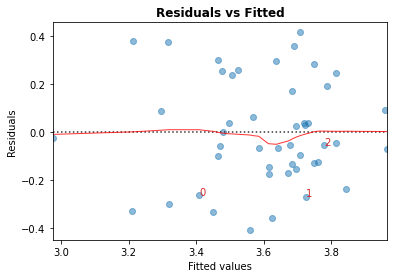

In [24]:
cls = Linear_Reg_Diagnostic(res9)
cls.residual_plot();

Volviendo a las comunas que se encuentran fuera de la Región Metropolitana, anteriormente se mencionó que, a mayor proporción de población rural, mayor tasa de defunciones por traumatismos. Inicialmente se hipotetizó que esto podría deberse a la dificultad de acceder a centro asistenciales, por lo que es probable que los accidentes ocurridos sean más letales. Una forma de probar esta hipótesis es incorporar al modelo la variable 'tiempo promedio en minutos al hospital o clínica más cercano', el cual forma parte de los indicadores de calidad de vida rural. Sin embargo, no se cuenta con este indicador para todas las comunas, por lo que se excluyen del análisis las siguientes: Iquique, Alto Hospicio, Antofagasta, Calama, Copiapó, La Serena, Coquimbo, Ovalle, Valparaíso, Viña del Mar, Los Andes, Quillota, Calera, San Antonio, San Felipe, Quilpué, Villa Alemana, Rancagua, Machalí, Rengo, San Fernando, Talca, Curicó, Linares, Concepción, Coronel, Chiguayante, San Pedro de la Paz, Talcahuano, Tomé, Hualpén, Los Angeles, Temuco, Angol, Puerto Montt, Puqueldón, Osorno, Coyhaique, Punta Arenas, Valdivia, Arica y Chillán.<br>Dado lo anterior, para realizar la comparación, primero se estima nuevamente el modelo 6, pero sin incluir las comunas mencionadas. Se observa que, para este subconjunto de comunas fuera de la Región Metropolitana, la proporción de población rural no tiene un efecto significativo en la tasa de defunciones por traumatismos. Asimismo, el R cuadrado disminuye de 0.120 en el modelo 6 a 0.075 en el modelo 10, lo que indicaría que el modelo 6 es mejor, aunque según los indicadores AIC y BIC, es el modelo 10 el mejor.

In [25]:
mod10 = smf.ols(formula='tasa_def ~ ingreso + prop_rural + etnia + tasa_denuncias', data=data_otras2)
res10 = mod10.fit()
params10 = res10.params
print('Modelo 10: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana\nexcluyendo comunas sin información sobre tiempo en minutos a hospital o clínica más cercana')
print(res10.summary())

Modelo 10: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana
excluyendo comunas sin información sobre tiempo en minutos a hospital o clínica más cercana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     4.542
Date:                Sun, 16 Oct 2022   Prob (F-statistic):            0.00151
Time:                        20:33:00   Log-Likelihood:                -1088.4
No. Observations:                 230   AIC:                             2187.
Df Residuals:                     225   BIC:                             2204.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
             

Ahora bien, el modelo 11 incluye la variable tiempo en minutos al hospital o clínica más cercana, el cual indica que el coeficiente de esta variable no es significativo, por lo que no es posible afirmar que existe una asociación entre el tiempo al hospital o clínica más cercana y la tasa de defunciones por traumatismos, manteniendo las demás variables constantes. En relación al resto de las variables del modelo, solamente la proporción que se identifica con un pueblo originario tiene un efecto significativo. En cuanto a la bondad del ajuste del modelo, el R cuadrado es levemente mayor al modelo 10, y los indicadores AIC y BIC son muy similares. En cambio, respecto al modelo 10, el R cuadrado es menor, y los indicadores AIC y BIC también lo son.

In [26]:
mod11 = smf.ols(formula='tasa_def ~ ingreso + prop_rural + etnia + tasa_denuncias + tiempo_hospital', data=data_otras2)
res11 = mod11.fit()
params11 = res11.params
print('Modelo 11: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana\nincluyendo la variable tiempo en minutos a hospital o clínica más cercana')
print(res11.summary())

Modelo 11: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana
incluyendo la variable tiempo en minutos a hospital o clínica más cercana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     4.175
Date:                Sun, 16 Oct 2022   Prob (F-statistic):            0.00120
Time:                        20:33:00   Log-Likelihood:                -1087.0
No. Observations:                 230   AIC:                             2186.
Df Residuals:                     224   BIC:                             2207.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    s

## Conclusiones
En el presente informe se analizó la asociación entre el nivel de ingresos, así como la proporción de población rural, proporción que se identifica con un pueblo originario, tasa de denuncias de delitos de mayor connotación social y tiempo en minutos al hospital o clínica más cercana (este último solo para comunas fuera de la Región Metropolitana), con la tasa de defunciones debido a traumatismos. Este análisis se realiza, de forma separada, para las comunas de la Región Metropolitana y para las que no pertenecen a dicha región.<br>En el caso de las comunas que pertenecen a la Región Metropolitana, el modelo escogido es el 7, el cual incluye todas las variables, transformación logarítmica para las variables ingresos y tasa de defunciones por traumatismos, y todas las comunas. Esta elección se debe a que es el segundo modelo con mejor bondad del ajuste y, si bien el modelo 9 tiene mejores indicadores de R cuadrado, AIC y BIC, excluye las cinco comunas con mejores ingresos debido a que tienen un comportamiento atípico. Por lo tanto, si bien el modelo 9 tiene mejor poder predictivo, no incluye todas las comunas de la Región Metropolitana, por lo que no es completamente representativo de la realidad de esta región.<br> Los resultados de este modelo indican que, a mayor ingreso promedio de los hogares, menor es la tasa de defunciones por traumatismos de la comuna, controlando por el resto de las variables. Esto indica que las personas de menor nivel socioeconómico tienen una mayor probabilidad de morir por causas externas, lo que podría explicar en parte la menor esperanza de vida de estas personas. Este fenómeno podría deberse a que en las comunas de menores ingresos las personas trabajan en empleos menos calificados, los cuales son más riesgosos, estando más expuestos a accidentes. Otro factor que puede incidir es que las personas de menores recursos están expuestos a ambientes más violentos y con más delincuencia. Si bien la variable tasa de denuncias de delitos de mayor connotación social no tiene un coeficiente significativo, las denuncias pueden no reflejar los delitos que realmente ocurren, ya que no todos los delitos se denuncian. Esto puede explicarse por una desconfianza en las instituciones, la cual probablemente es mayor en comunas de menores ingresos, sumado al hecho de que en la mayoría de los casos quien denuncia es la víctima y, si esta falleció, es menos probable que se denuncie.<br>En cuanto a las variables proporción que se identifica con un pueblo originario y proporción que vive en zonas rurales, el hecho de que el coeficiente no sea significativo puede deberse a que dichas proporciones son bajas. Asimismo, al vivir en la Región Metropolitana, aunque la persona viva en zonas rurales y/o se identifique con un pueblo indígena, al estar más cercano a zonas urbanas tiene mayor acceso a servicios de urgencia y, además, culturalmente son más similares a quienes viven en zonas urbanas. 

In [27]:
print('Modelo 7: modelo regresión lineal múltiple con transformación logarítmica, para las comunas de la Región Metropolitana')
print(res7.summary())

Modelo 7: modelo regresión lineal múltiple con transformación logarítmica, para las comunas de la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:           tasa_def_log   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     9.540
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           9.90e-06
Time:                        20:33:00   Log-Likelihood:                 1.2842
No. Observations:                  52   AIC:                             7.432
Df Residuals:                      47   BIC:                             17.19
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------

En las comunas que no pertenecen a la Región Metropolitana, el modelo escogido es el modelo 6. De acuerdo con el R cuadrado, este modelo es el que mejor explica la variable tasa de defunciones, aunque según el AIC y el BIC son mejores los modelos 10 y 11. Sin embargo, estos modelos incluyen la variable tiempo en minutos al hospital o clínica más cercana, la cual no está disponible para todas las comunas, por lo que se excluyen varias y su representatividad es más acotada. Además, el coeficiente de regresión de la variable tiempo en minutos al hospital o clínica más cercana no es significativo, lo que indicaría que esta variable no es relevante en el modelo.<br>Los resultados de este modelo indican que a mayor proporción de población rural y mayor proporción de personas que se identifican con un pueblo originario, mayor tasa de mortalidad por traumatismos, manteniendo el resto de las variables constantes. En cambio, los coeficientes de las variables ingresos y tasa de denuncias de delitos de mayor connotación social, no son significativos. La asociación de la proporción de población rural y población que se identifica con pueblos originarios podría deberse a factores culturales, que inciden tanto en los riesgos a los que se ven expuestos como en la predisposición a recibir tratamientos.

In [28]:
print('Modelo 6: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana')
print(res6.summary())

Modelo 6: modelo regresión lineal múltiple para las comunas no pertenecientes a la Región Metropolitana
                            OLS Regression Results                            
Dep. Variable:               tasa_def   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     9.107
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           6.55e-07
Time:                        20:33:00   Log-Likelihood:                -1269.7
No. Observations:                 272   AIC:                             2549.
Df Residuals:                     267   BIC:                             2567.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Los diferentes resultados para las comunas de la Región Metropolitana y el resto del país, comprueban la hipótesis inicial de que los factores que inciden en la tasa de mortalidad pueden variar en distintas zonas del país. De este modo, dado que en la Región Metropolitana existe una alta homogeneidad intracomunal y alta heterogeneidad intercomunal, la comuna a la que pertenece una persona refleja de mejor forma su nivel socioeconómico. De este modo, el nivel socioeconómico de la comuna predice de buena forma la tasa de mortalidad por traumatismos. Esto no es así en las comunas que están fuera de la Región Metropolitana, donde la proporción de población rural y que se identifica con un pueblo originario sí tienen una asociación con la variable de interés. Lo anterior no necesariamente quiere decir que el nivel socioeconómico no influya en la probabilidad de morir por traumatismos, sino que, como los datos están a nivel de comuna, es probable que las comunas fuera de la Región Metropolitana tengan mayor heterogeneidad interna, de modo que el promedio de ingresos no logra predecir bien la tasa de mortalidad por traumatismos. Esto es consecuencia de una de las limitaciones del estudio, ya que se trabaja con datos agregados y, por ende, se puede caer en falacia ecológica (asumir que el comportamiento de todos los individuos que pertenecen a un grupo es igual). Por lo tanto, una posible línea de investigación es realizar este análisis pero con datos a nivel de persona, sin embargo, esta información puede ser difícil de obtener. Otra limitación del estudio es que se agrupa a todas las regiones que están fuera de la Metropolitana, sin embargo, no necesariamente comparten una cultura en común, por lo que también sería interesante indagar en estos aspectos. 

## Bibliografía
Bilal, U., Alazraqui, M., Caiaffa, W. T., Lopez-Olmedo, N., Martinez-Folgar, K., Miranda, J. J., Rodriguez D., Vives A. & Diez-Roux, A. V. (2019). Inequalities in life expectancy in six large Latin American cities from the SALURBAL study: an ecological analysis. The lancet planetary health, 3 (12), e503-e510.

ONU. (2009). *Comisión sobre Determinantes Sociales de Salud. Informe de la Secretaría*.